In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from lightgbm import LGBMClassifier
import optuna
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from library.Data_Preprocessing import Balance_Ratio
from library.Imbalance_Sampling import label_divide, under_over, over_under
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, all_optuna, optuna_history

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### Balance Cascade

In [16]:
# train & test of balance cascade (scheme 1 & 2)
class BalanceCascade:
    
    def __init__(self, base_clf = 'LightGBM', num_iter = 10, over_method = None, under_method = 'NM', 
                 over_num = 5, verbose = True):
        self.classifier = base_clf
        self.num_iter = num_iter
        self.over_method = over_method
        self.under_method = under_method
        self.over_num = over_num if over_method else 1
        self.verbose = verbose
        if over_method not in ['ADASYN', 'SMOTEN', None]:
            raise Exception(f'{over_method} is not implemented !') 
        if under_method not in ['NM', 'random']:
            raise Exception(f'{under_method} is not implemented !') 
        if base_clf not in ['LightGBM', 'RandomForest']:
            raise Exception(f'{base_clf} is not implemented !') 
    
    
    def training(self, train_data, clf_config):
        origin_good = train_data[train_data.GB == 0]
        origin_bad = train_data[train_data.GB == 1] 
        br_0 = (len(origin_bad)*self.over_num) / len(origin_good)
        false_rate = br_0**(1/(self.num_iter - 1))
        
        keep_bad = origin_bad.copy()
        keep_good = {0: origin_good.copy()}
        br_list = []
        clf_threshold = []
        clf_cascade = {}
        for j in range(self.num_iter):
            temp_train = pd.concat([keep_good[j], keep_bad], axis = 0)
            if self.verbose:
                print(f'Iteration {j+1}:')
                print('Size before undersampling:', len(temp_train))
            temp_br = len(keep_bad) / len(keep_good[j])
            br_list.append(temp_br)

            # undersampling first
            if j < (self.num_iter - 1):
                under_ratio = 1/self.over_num
                under_X, under_Y = over_under(temp_train, None, self.under_method, 0, under_ratio)
                temp_combine = pd.concat([under_X, under_Y], axis = 1)
            else:
                temp_combine = temp_train.copy()
                if self.verbose:
                    print('Stop Undersampling !')            
            under_good = temp_combine[temp_combine.GB == 0]
            
            # oversampling
            if all([self.over_method, len(under_good) > len(keep_bad)]):
                over_ratio = 1
                over_X, over_Y = under_over(temp_combine, self.over_method, None, over_ratio, 0)
                over_sample = pd.concat([over_X, over_Y], axis = 1)
                train_combine = over_sample.rename({0: 'GB'}, axis = 'columns')
            else:
                train_combine = temp_combine.copy()
                if self.verbose:
                    print('Stop Oversampling !')

            # train the base learner, find the threshold, and discard the redundant good instances
            valid_good = keep_good[j].copy()
            train_x, train_y, valid_x, valid_y = label_divide(train_combine, valid_good, 'GB', train_only = False)
            if self.classifier == 'LightGBM':
                clf = LGBMClassifier(**clf_config)
            elif self.classifier == 'RandomForest':
                clf = RandomForestClassifier(**clf_config)
            clf.fit(train_x, train_y)
            predict = clf.predict_proba(valid_x)[:, 1]
            predict_df = pd.DataFrame(dict(predict = predict), index = valid_x.index)
            predict_df = predict_df.sort_values(by = 'predict', ascending = False)
            keep_num = int(len(predict_df)*false_rate) + 1
            keep_index = predict_df.index[:keep_num]
            threshold = predict_df.loc[keep_index[-1]].values[0]
            clf_threshold.append(threshold)
            clf_cascade[j] = clf
            
            if j != (self.num_iter - 1):
                keep_good[j+1] = keep_good[j].loc[keep_index].copy()        
        self.good_data = keep_good
        self.bad_data = keep_bad
        self.threshold = clf_threshold
        self.cascade = clf_cascade
        self.balance_ratio = br_list
    
    
    def testing(self, test_data):
        clf_cascade = self.cascade
        if isinstance(self.threshold, int):
            clf_threshold = [self.threshold]*len(clf_cascade)
        else:
            clf_threshold = self.threshold

        test_x, test_y = label_divide(test_data, 'GB', train_only = True)
        predict_df = pd.DataFrame()
        for i in range(len(clf_cascade)):
            clf = clf_cascade[i]
            predict = clf.predict_proba(test_x)[:, 1]
            answer = (predict > clf_threshold[i]).astype(int)
            predict = pd.DataFrame({str(i): answer})
            predict_df = pd.concat([predict_df, predict], axis = 1)
        predict_y = (predict_df.apply(sum, axis = 1) == len(clf_cascade)).astype(int)
        result = pd.DataFrame(dict(predict = predict_y, truth = test_y))

        return result


# run all resampling datasets
def runall_cascade(train_set, test_data, base_config, base_clf = 'LightGBM', num_iter = 10, meta_config = None):
    
    num_set = len(train_set)
    table_set = pd.DataFrame()
    for i in range(1, num_set):
        print('\n', f'Dataset {i}:')
        if isinstance(meta_config, dict):
            BC = BalanceCascade(base_clf = base_clf, **meta_config[f'set{i}'])
        else:
            BC = BalanceCascade(base_clf = base_clf, num_iter = num_iter)
        BC.training(train_set[f'set{i}'], base_config[f'set{i}'])
        result = BC.testing(test_data)
        table = cf_matrix(result, train_set[f'set{i}'].GB)
        table_set = pd.concat([table_set, table]).rename(index = {0: f'dataset {i}'})
    
    return table_set

### Optuna

In [23]:
# creator of optuna study for balance cascade
def BalanceCascade_creator(train_data, mode, num_valid = 3, label = 'GB') :

    def objective(trial) :
    
        base_param = {
            'n_estimators': trial.suggest_categorical('n_estimators', [100, 300, 500, 1000]),
            'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.325, step = 0.05),
            'max_depth': trial.suggest_int('max_depth', 3, 12, step = 3),
            'num_leaves': trial.suggest_int('num_leaves', 10, 130, step = 20),
            'min_child_samples': trial.suggest_categorical('min_child_samples', [10, 50, 100, 500, 1000, 5000]),
            'min_split_gain': trial.suggest_int('min_split_gain', 0, 12, step = 2),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 0.9, step = 0.2),
            'subsample': trial.suggest_float('subsample', 0.3, 0.9, step = 0.2),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-2, 10), # alpha
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-2, 10) # lambda
        }
    
        meta_param = {
            'num_iter': trial.suggest_int('num_iter', 5, 5, step = 5),
            'over_num': trial.suggest_int('over_num', 5, 5, step = 5),
            'over_method': trial.suggest_categorical('over_method', ['ADASYN']),
            'under_method': trial.suggest_categorical('under_method', ['NM'])
        }  

        result_list = []
        for i in range(num_valid):

            train_good = train_data[train_data.GB == 0]
            train_bad = train_data[train_data.GB == 1]
            train_good_x, train_good_y = label_divide(train_good, None, label, train_only = True)
            train_bad_x, train_bad_y = label_divide(train_bad, None, label, train_only = True)
            train_g_x, valid_g_x, train_g_y, valid_g_y = train_test_split(train_good_x, train_good_y, test_size = 0.25)
            train_b_x, valid_b_x, train_b_y, valid_b_y = train_test_split(train_bad_x, train_bad_y, test_size = 0.25)
            train_x = pd.concat([train_g_x, train_b_x], axis = 0)
            train_y = pd.concat([train_g_y, train_b_y], axis = 0)
            valid_x = pd.concat([valid_g_x, valid_b_x], axis = 0)
            valid_y = pd.concat([valid_g_y, valid_b_y], axis = 0)
            all_train = pd.concat([train_x, train_y], axis = 1)
            all_valid = pd.concat([valid_x, valid_y], axis = 1)

            if mode == 1:
                BC = BalanceCascade(num_iter = meta_param['num_iter'], under_method = meta_param['under_method'])
            elif mode == 2:
                BC = BalanceCascade(num_iter = meta_param['num_iter'], over_method = meta_param['over_method'], 
                                    under_method = meta_param['under_method'], over_num = meta_param['over_num'])
            BC.training(all_train, base_param)
            result = BC.testing(all_valid)
            table = cf_matrix(result, valid_y)
            recall = table['Recall'].values
            precision = table['Precision'].values
            beta = 1
            if recall > 0:
                fscore = ((1+beta**2)*recall*precision) / (recall+(beta**2)*precision) 
            else:
                fscore = 0
            result_list.append(fscore)

        return np.mean(result_list)
    return objective

## 

### Load Data

In [4]:
### training data ###
training_month = range(2, 5)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 2:

Dimension of dataset 0 : (39009, 88)  balance ratio: 564.35
Dimension of dataset 1 : (8970, 88)  balance ratio: 25.0
Dimension of dataset 2 : (8892, 88)  balance ratio: 25.0
Dimension of dataset 3 : (8944, 88)  balance ratio: 25.0
Dimension of dataset 4 : (8944, 88)  balance ratio: 25.0
Dimension of dataset 5 : (8970, 88)  balance ratio: 25.0
Dimension of dataset 6 : (8969, 88)  balance ratio: 25.07
Dimension of dataset 7 : (8967, 88)  balance ratio: 25.22
Dimension of dataset 8 : (8970, 88)  balance ratio: 25.0
Dimension of dataset 9 : (1794, 88)  balance ratio: 25.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 3:

Dimension of dataset 0 : (60396, 97)  balance ratio: 533.48
Dimension of dataset 1 : (14924, 97)  balance ratio: 25.0
Dimension of dataset 2 : (14560, 97)  balance ratio: 25.0
Dimension of dataset 3 : (14664, 97)  balance ratio: 25.0
Dimension of dataset 4 : (14664, 97)  balance ratio: 25.0
Dimension of dataset 5 : (14674, 97)  balance ra

### Search for the Best Hyperparameters

In [24]:
best_paramC, all_scoreC = all_optuna(all_data = run_train, 
                                     mode = 2, 
                                     TPE_multi = False, 
                                     n_iter = 25,
                                     filename = 'runhist_array_m2m4_m5_3criteria_iter5_over5_nlast_BalanceCascade',
                                     creator = BalanceCascade_creator
                                    )

meta_item = ['num_iter', 'over_num', 'over_method', 'under_method']
base_paramC = {}
meta_paramC = {}
for i in range(1, len(run_train)):
    base_paramC.update({f'set{i}': {}})
    meta_paramC.update({f'set{i}': {}})
    [base_paramC[f'set{i}'].update({a: b}) for (a, b) in best_paramC[f'set{i}'].items() if a not in meta_item]
    [meta_paramC[f'set{i}'].update({a: b}) for (a, b) in best_paramC[f'set{i}'].items() if a in meta_item]

  0%|          | 0/9 [00:00<?, ?it/s]

[I 2022-03-08 09:37:38,251] A new study created in memory with name: no-name-12c41f85-d99c-4346-b909-95b3007b24df


Dataset 1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Iteration 1:
Size before undersampling: 30068
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11562
Iteration 2:
Size before undersampling: 20489
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11565
Iteration 3:
Size before undersampling: 14084
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11553
Iteration 4:
Size before undersampling: 9801
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11587
Iteration 5:
Size before undersampling: 6937
Stop Undersampling !
Size before Oversampling: 6937
Size after Oversampling: 11561
Precision: 0.014084507042253521 
Recall: 0.03614457831325301 
Aging Rate: 0.08613020622725434
Iteration 1:
Size before undersampling: 30068
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11580
Iteration 2:
Size before undersampling: 20489
Size after Undersampling: 6936
Size be

Iteration 1:
Size before undersampling: 30068
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11553
Iteration 2:
Size before undersampling: 20489
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11589
Iteration 3:
Size before undersampling: 14084
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11534
Iteration 4:
Size before undersampling: 9801
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11583
Iteration 5:
Size before undersampling: 6937
Stop Undersampling !
Size before Oversampling: 6937
Size after Oversampling: 11614
Precision: 0.0158311345646438 
Recall: 0.07317073170731707 
Aging Rate: 0.1512370311252993
Iteration 1:
Size before undersampling: 30068
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11564
Iteration 2:
Size before undersampling: 20489
Size after Undersampling: 6936
Size befor

Iteration 1:
Size before undersampling: 30068
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11590
Iteration 2:
Size before undersampling: 20489
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11547
Iteration 3:
Size before undersampling: 14084
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11528
Iteration 4:
Size before undersampling: 9801
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11531
Iteration 5:
Size before undersampling: 6937
Stop Undersampling !
Size before Oversampling: 6937
Size after Oversampling: 11592
Precision: 0.028985507246376812 
Recall: 0.14457831325301204 
Aging Rate: 0.16383062920459043
Iteration 1:
Size before undersampling: 30068
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11577
Iteration 2:
Size before undersampling: 20489
Size after Undersampling: 6936
Size be

Iteration 1:
Size before undersampling: 30068
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11571
Iteration 2:
Size before undersampling: 20489
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11529
Iteration 3:
Size before undersampling: 14084
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11577
Iteration 4:
Size before undersampling: 9801
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11562
Iteration 5:
Size before undersampling: 6937
Stop Undersampling !
Size before Oversampling: 6937
Size after Oversampling: 11529
Precision: 0.035211267605633804 
Recall: 0.19480519480519481 
Aging Rate: 0.17087845968712395
Iteration 1:
Size before undersampling: 30068
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11610
Iteration 2:
Size before undersampling: 20489
Size after Undersampling: 6936
Size be

Iteration 1:
Size before undersampling: 30068
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11609
Iteration 2:
Size before undersampling: 20489
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11562
Iteration 3:
Size before undersampling: 14084
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11558
Iteration 4:
Size before undersampling: 9801
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11567
Iteration 5:
Size before undersampling: 6937
Stop Undersampling !
Size before Oversampling: 6937
Size after Oversampling: 11527
Precision: 0.015503875968992248 
Recall: 0.06976744186046512 
Aging Rate: 0.1552346570397112
Iteration 1:
Size before undersampling: 30068
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11536
Iteration 2:
Size before undersampling: 20489
Size after Undersampling: 6936
Size bef

Iteration 1:
Size before undersampling: 30068
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11576
Iteration 2:
Size before undersampling: 20489
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11530
Iteration 3:
Size before undersampling: 14084
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11538
Iteration 4:
Size before undersampling: 9801
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11547
Iteration 5:
Size before undersampling: 6937
Stop Undersampling !
Size before Oversampling: 6937
Size after Oversampling: 11543
Precision: 0.035555555555555556 
Recall: 0.08888888888888889 
Aging Rate: 0.0907258064516129
Iteration 1:
Size before undersampling: 30068
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11536
Iteration 2:
Size before undersampling: 20489
Size after Undersampling: 6936
Size bef

Iteration 1:
Size before undersampling: 30068
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11575
Iteration 2:
Size before undersampling: 20489
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11544
Iteration 3:
Size before undersampling: 14084
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11544
Iteration 4:
Size before undersampling: 9801
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11545
Iteration 5:
Size before undersampling: 6937
Stop Undersampling !
Size before Oversampling: 6937
Size after Oversampling: 11552
Precision: 0.042483660130718956 
Recall: 0.1326530612244898 
Aging Rate: 0.12308930008045052
Iteration 1:
Size before undersampling: 30068
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11546
Iteration 2:
Size before undersampling: 20489
Size after Undersampling: 6936
Size bef

Iteration 1:
Size before undersampling: 30068
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11556
Iteration 2:
Size before undersampling: 20489
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11562
Iteration 3:
Size before undersampling: 14084
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11590
Iteration 4:
Size before undersampling: 9801
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11559
Iteration 5:
Size before undersampling: 6937
Stop Undersampling !
Size before Oversampling: 6937
Size after Oversampling: 11561
Precision: 0.023696682464454975 
Recall: 0.10526315789473684 
Aging Rate: 0.1691382765531062
Iteration 1:
Size before undersampling: 30068
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11577
Iteration 2:
Size before undersampling: 20489
Size after Undersampling: 6936
Size bef

Iteration 1:
Size before undersampling: 30068
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11591
Iteration 2:
Size before undersampling: 20489
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11542
Iteration 3:
Size before undersampling: 14084
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11568
Iteration 4:
Size before undersampling: 9801
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11570
Iteration 5:
Size before undersampling: 6937
Stop Undersampling !
Size before Oversampling: 6937
Size after Oversampling: 11587
Precision: 0.023376623376623377 
Recall: 0.11688311688311688 
Aging Rate: 0.1547427652733119
Iteration 1:
Size before undersampling: 30068
Size after Undersampling: 6936
Size before Oversampling: 6936
Size after Oversampling: 11530
Iteration 2:
Size before undersampling: 20489
Size after Undersampling: 6936
Size bef

[I 2022-03-08 09:47:07,409] A new study created in memory with name: no-name-be8d3c0e-4c9a-4346-8dbd-8be6bf344c58


Precision: 0.030690537084398978 
Recall: 0.14634146341463414 
Aging Rate: 0.15842787682333873
[I 2022-03-08 09:47:07,316] Trial 24 finished with value: 0.04489692390962186 and parameters: {'n_estimators': 1000, 'learning_rate': 0.275, 'max_depth': 3, 'num_leaves': 70, 'min_child_samples': 500, 'min_split_gain': 4, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 5.548361563393753, 'reg_lambda': 0.01038824410802033, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 14 with value: 0.06273397004015947.
Sampler is TPESampler
Dataset 2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Iteration 1:
Size before undersampling: 29464
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11322
Iteration 2:
Size before undersampling: 20079
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11370
Iteration 3:
Size before undersampling: 13803
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11292
Iteration 4:
Size before undersampling: 9606
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11278
Iteration 5:
Size before undersampling: 6799
Stop Undersampling !
Size before Oversampling: 6799
Size after Oversampling: 11402
Precision: 0.041304347826086954 
Recall: 0.20652173913043478 
Aging Rate: 0.18290258449304175
Iteration 1:
Size before undersampling: 29464
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11335
Iteration 2:
Size before undersampling: 20079
Size after Undersampling: 6798
Size be

Iteration 1:
Size before undersampling: 29464
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11296
Iteration 2:
Size before undersampling: 20079
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11293
Iteration 3:
Size before undersampling: 13803
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11366
Iteration 4:
Size before undersampling: 9606
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11374
Iteration 5:
Size before undersampling: 6799
Stop Undersampling !
Size before Oversampling: 6799
Size after Oversampling: 11388
Precision: 0.029023746701846966 
Recall: 0.13095238095238096 
Aging Rate: 0.1540650406504065
Iteration 1:
Size before undersampling: 29464
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11326
Iteration 2:
Size before undersampling: 20079
Size after Undersampling: 6798
Size bef

Iteration 1:
Size before undersampling: 29464
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11322
Iteration 2:
Size before undersampling: 20079
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11304
Iteration 3:
Size before undersampling: 13803
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11342
Iteration 4:
Size before undersampling: 9606
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11261
Iteration 5:
Size before undersampling: 6799
Stop Undersampling !
Size before Oversampling: 6799
Size after Oversampling: 11299
Precision: 0.027160493827160494 
Recall: 0.12941176470588237 
Aging Rate: 0.1682592438720399
Iteration 1:
Size before undersampling: 29464
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11322
Iteration 2:
Size before undersampling: 20079
Size after Undersampling: 6798
Size bef

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-08 09:50:02,469] Trial 7 finished with value: 0.04038122863358542 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 5000, 'min_split_gain': 10, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.6757862444999528, 'reg_lambda': 0.36110262763779377, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 1 with value: 0.059068428891779635.
Iteration 1:
Size before undersampling: 29464
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11360
Iteration 2:
Size before undersampling: 20079
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11290
Iteration 3:
Size before undersampling: 13803
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11361
Iteration 4:
Size before undersampling: 9606
Size after Undersampling: 6798
Siz

Iteration 5:
Size before undersampling: 6799
Stop Undersampling !
Size before Oversampling: 6799
Size after Oversampling: 11370
Precision: 0.02506265664160401 
Recall: 0.13513513513513514 
Aging Rate: 0.16597337770382695
[I 2022-03-08 09:51:41,954] Trial 10 finished with value: 0.055452457390441884 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 9, 'num_leaves': 130, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 7.941746445422151, 'reg_lambda': 6.7811952599707395, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 9 with value: 0.07249781244109064.
Iteration 1:
Size before undersampling: 29464
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11308
Iteration 2:
Size before undersampling: 20079
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11395
Iteration 3:
Size before un

Iteration 4:
Size before undersampling: 9606
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11291
Iteration 5:
Size before undersampling: 6799
Stop Undersampling !
Size before Oversampling: 6799
Size after Oversampling: 11272
Precision: 0.024336283185840708 
Recall: 0.13924050632911392 
Aging Rate: 0.18456512862392813
[I 2022-03-08 09:53:03,491] Trial 13 finished with value: 0.04565509790102449 and parameters: {'n_estimators': 500, 'learning_rate': 0.17500000000000002, 'max_depth': 12, 'num_leaves': 110, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.4816963671709878, 'reg_lambda': 1.4203249438229535, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 9 with value: 0.07249781244109064.
Iteration 1:
Size before undersampling: 29464
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11363
Iteration 2:
Size before un

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Iteration 1:
Size before undersampling: 29464
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11296
Iteration 2:
Size before undersampling: 20079
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11325
Iteration 3:
Size before undersampling: 13803
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11358
Iteration 4:
Size before undersampling: 9606
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11309
Iteration 5:
Size before undersampling: 6799
Stop Undersampling !
Size before Oversampling: 6799
Size after Oversampling: 11352
Precision: 0.038461538461538464 
Recall: 0.06896551724137931 
Aging Rate: 0.06516290726817042
[I 2022-03-08 09:53:48,209] Trial 15 finished with value: 0.04131966241194113 and parameters: {'n_estimators': 1000, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_lea

Iteration 5:
Size before undersampling: 6799
Stop Undersampling !
Size before Oversampling: 6799
Size after Oversampling: 11337
Precision: 0.014527845036319613 
Recall: 0.07317073170731707 
Aging Rate: 0.1680227827502034
Iteration 1:
Size before undersampling: 29464
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11358
Iteration 2:
Size before undersampling: 20079
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11379
Iteration 3:
Size before undersampling: 13803
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11284
Iteration 4:
Size before undersampling: 9606
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11370
Iteration 5:
Size before undersampling: 6799
Stop Undersampling !
Size before Oversampling: 6799
Size after Oversampling: 11414
Precision: 0.03667481662591687 
Recall: 0.17045454545454544 
Aging Rate: 0.16721177432542927
[I 

Iteration 4:
Size before undersampling: 9606
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11298
Iteration 5:
Size before undersampling: 6799
Stop Undersampling !
Size before Oversampling: 6799
Size after Oversampling: 11361
Precision: 0.022675736961451247 
Recall: 0.11494252873563218 
Aging Rate: 0.18444165621079048
Iteration 1:
Size before undersampling: 29464
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11372
Iteration 2:
Size before undersampling: 20079
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11294
Iteration 3:
Size before undersampling: 13803
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11287
Iteration 4:
Size before undersampling: 9606
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11366
Iteration 5:
Size before undersampling: 6799
Stop Undersampling !
Size before Oversam

Iteration 3:
Size before undersampling: 13803
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11227
Iteration 4:
Size before undersampling: 9606
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11299
Iteration 5:
Size before undersampling: 6799
Stop Undersampling !
Size before Oversampling: 6799
Size after Oversampling: 11415
Precision: 0.03881278538812785 
Recall: 0.20238095238095238 
Aging Rate: 0.1806930693069307
Iteration 1:
Size before undersampling: 29464
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11346
Iteration 2:
Size before undersampling: 20079
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11275
Iteration 3:
Size before undersampling: 13803
Size after Undersampling: 6798
Size before Oversampling: 6798
Size after Oversampling: 11376
Iteration 4:
Size before undersampling: 9606
Size after Undersampling: 6798
Size befor

[I 2022-03-08 09:57:30,193] A new study created in memory with name: no-name-af69850a-85fe-42a6-81a9-e01731b10c7e


Precision: 0.019184652278177457 
Recall: 0.10256410256410256 
Aging Rate: 0.17097170971709716
[I 2022-03-08 09:57:30,130] Trial 24 finished with value: 0.054155630723178694 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 9, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_bytree': 0.5, 'subsample': 0.3, 'reg_alpha': 0.03235346400359454, 'reg_lambda': 0.7173851357426967, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 9 with value: 0.07249781244109064.
Sampler is TPESampler
Dataset 3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Iteration 1:
Size before undersampling: 29562
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11490
Iteration 2:
Size before undersampling: 20146
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11386
Iteration 3:
Size before undersampling: 13850
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11329
Iteration 4:
Size before undersampling: 9639
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11371
Iteration 5:
Size before undersampling: 6823
Stop Undersampling !
Size before Oversampling: 6823
Size after Oversampling: 11381
Precision: 0.03431372549019608 
Recall: 0.16279069767441862 
Aging Rate: 0.163855421686747
Iteration 1:
Size before undersampling: 29562
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11500
Iteration 2:
Size before undersampling: 20146
Size after Undersampling: 6822
Size befor

Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11288
Iteration 2:
Size before undersampling: 20146
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11403
Iteration 3:
Size before undersampling: 13850
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11563
Iteration 4:
Size before undersampling: 9639
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11424
Iteration 5:
Size before undersampling: 6823
Stop Undersampling !
Size before Oversampling: 6823
Size after Oversampling: 11357
Precision: 0.034666666666666665 
Recall: 0.14285714285714285 
Aging Rate: 0.15592515592515593
Iteration 1:
Size before undersampling: 29562
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11401
Iteration 2:
Size before undersampling: 20146
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversamplin

Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11393
Iteration 2:
Size before undersampling: 20146
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11324
Iteration 3:
Size before undersampling: 13850
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11184
Iteration 4:
Size before undersampling: 9639
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11525
Iteration 5:
Size before undersampling: 6823
Stop Undersampling !
Size before Oversampling: 6823
Size after Oversampling: 11400
Precision: 0.023255813953488372 
Recall: 0.10714285714285714 
Aging Rate: 0.15567176186645212
Iteration 1:
Size before undersampling: 29562
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11296
Iteration 2:
Size before undersampling: 20146
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversamplin

Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11334
Iteration 2:
Size before undersampling: 20146
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11474
Iteration 3:
Size before undersampling: 13850
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11491
Iteration 4:
Size before undersampling: 9639
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11404
Iteration 5:
Size before undersampling: 6823
Stop Undersampling !
Size before Oversampling: 6823
Size after Oversampling: 11300
Precision: 0.028503562945368172 
Recall: 0.15384615384615385 
Aging Rate: 0.16934835076427998
Iteration 1:
Size before undersampling: 29562
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11397
Iteration 2:
Size before undersampling: 20146
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversamplin

Iteration 1:
Size before undersampling: 29562
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11287
Iteration 2:
Size before undersampling: 20146
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11276
Iteration 3:
Size before undersampling: 13850
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11503
Iteration 4:
Size before undersampling: 9639
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11493
Iteration 5:
Size before undersampling: 6823
Stop Undersampling !
Size before Oversampling: 6823
Size after Oversampling: 11288
Precision: 0.03836317135549872 
Recall: 0.1875 
Aging Rate: 0.16387259010896899
Iteration 1:
Size before undersampling: 29562
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11447
Iteration 2:
Size before undersampling: 20146
Size after Undersampling: 6822
Size before Oversampl

Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11474
Iteration 2:
Size before undersampling: 20146
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11440
Iteration 3:
Size before undersampling: 13850
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11523
Iteration 4:
Size before undersampling: 9639
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11281
Iteration 5:
Size before undersampling: 6823
Stop Undersampling !
Size before Oversampling: 6823
Size after Oversampling: 11393
Precision: 0.029333333333333333 
Recall: 0.14666666666666667 
Aging Rate: 0.15169902912621358
Iteration 1:
Size before undersampling: 29562
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11375
Iteration 2:
Size before undersampling: 20146
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversamplin

Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11426
Iteration 2:
Size before undersampling: 20146
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11265
Iteration 3:
Size before undersampling: 13850
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11281
Iteration 4:
Size before undersampling: 9639
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11270
Iteration 5:
Size before undersampling: 6823
Stop Undersampling !
Size before Oversampling: 6823
Size after Oversampling: 11298
Precision: 0.0392156862745098 
Recall: 0.2 
Aging Rate: 0.1873469387755102
Iteration 1:
Size before undersampling: 29562
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11293
Iteration 2:
Size before undersampling: 20146
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11310
Iteration 

Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11376
Iteration 2:
Size before undersampling: 20146
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11505
Iteration 3:
Size before undersampling: 13850
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11260
Iteration 4:
Size before undersampling: 9639
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11220
Iteration 5:
Size before undersampling: 6823
Stop Undersampling !
Size before Oversampling: 6823
Size after Oversampling: 11277
Precision: 0.027649769585253458 
Recall: 0.1348314606741573 
Aging Rate: 0.17860082304526748
Iteration 1:
Size before undersampling: 29562
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11494
Iteration 2:
Size before undersampling: 20146
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling

Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11336
Iteration 2:
Size before undersampling: 20146
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11268
Iteration 3:
Size before undersampling: 13850
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11281
Iteration 4:
Size before undersampling: 9639
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11435
Iteration 5:
Size before undersampling: 6823
Stop Undersampling !
Size before Oversampling: 6823
Size after Oversampling: 11139
Precision: 0.0327455919395466 
Recall: 0.14444444444444443 
Aging Rate: 0.16493560448691316
Iteration 1:
Size before undersampling: 29562
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11516
Iteration 2:
Size before undersampling: 20146
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling:

[I 2022-03-08 10:07:50,215] A new study created in memory with name: no-name-9ca02cba-9c6f-4026-9c3d-77768ddc2eb3


Precision: 0.04185022026431718 
Recall: 0.19791666666666666 
Aging Rate: 0.18402918524523712
[I 2022-03-08 10:07:50,153] Trial 24 finished with value: 0.062159666479995025 and parameters: {'n_estimators': 1000, 'learning_rate': 0.17500000000000002, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 100, 'min_split_gain': 0, 'colsample_bytree': 0.9, 'subsample': 0.5, 'reg_alpha': 0.09551057193652573, 'reg_lambda': 0.016775789617230558, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 13 with value: 0.063078047037064.
Sampler is TPESampler
Dataset 4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Iteration 1:
Size before undersampling: 29600
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11371
Iteration 2:
Size before undersampling: 20170
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11364
Iteration 3:
Size before undersampling: 13865
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11376
Iteration 4:
Size before undersampling: 9649
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11380
Iteration 5:
Size before undersampling: 6830
Stop Undersampling !
Size before Oversampling: 6830
Size after Oversampling: 11391
Precision: 0.020618556701030927 
Recall: 0.058823529411764705 
Aging Rate: 0.0812395309882747
Iteration 1:
Size before undersampling: 29600
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11378
Iteration 2:
Size before undersampling: 20170
Size after Undersampling: 6828
Size be

Iteration 1:
Size before undersampling: 29600
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11404
Iteration 2:
Size before undersampling: 20170
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11388
Iteration 3:
Size before undersampling: 13865
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11372
Iteration 4:
Size before undersampling: 9649
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11375
Iteration 5:
Size before undersampling: 6830
Stop Undersampling !
Size before Oversampling: 6830
Size after Oversampling: 11382
Precision: 0.03217821782178218 
Recall: 0.13829787234042554 
Aging Rate: 0.16611842105263158
Iteration 1:
Size before undersampling: 29600
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11363
Iteration 2:
Size before undersampling: 20170
Size after Undersampling: 6828
Size bef

Iteration 1:
Size before undersampling: 29600
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11365
Iteration 2:
Size before undersampling: 20170
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11367
Iteration 3:
Size before undersampling: 13865
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11390
Iteration 4:
Size before undersampling: 9649
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11364
Iteration 5:
Size before undersampling: 6830
Stop Undersampling !
Size before Oversampling: 6830
Size after Oversampling: 11364
Precision: 0.035629453681710214 
Recall: 0.16129032258064516 
Aging Rate: 0.17211774325429272
Iteration 1:
Size before undersampling: 29600
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11382
Iteration 2:
Size before undersampling: 20170
Size after Undersampling: 6828
Size be

Iteration 1:
Size before undersampling: 29600
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11369
Iteration 2:
Size before undersampling: 20170
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11397
Iteration 3:
Size before undersampling: 13865
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11374
Iteration 4:
Size before undersampling: 9649
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11382
Iteration 5:
Size before undersampling: 6830
Stop Undersampling !
Size before Oversampling: 6830
Size after Oversampling: 11390
Precision: 0.04316546762589928 
Recall: 0.15 
Aging Rate: 0.1115569823434992
Iteration 1:
Size before undersampling: 29600
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11357
Iteration 2:
Size before undersampling: 20170
Size after Undersampling: 6828
Size before Oversampling

Iteration 1:
Size before undersampling: 29600
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11393
Iteration 2:
Size before undersampling: 20170
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11374
Iteration 3:
Size before undersampling: 13865
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11378
Iteration 4:
Size before undersampling: 9649
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11359
Iteration 5:
Size before undersampling: 6830
Stop Undersampling !
Size before Oversampling: 6830
Size after Oversampling: 11389
Precision: 0.018306636155606407 
Recall: 0.09876543209876543 
Aging Rate: 0.17571371129875352
Iteration 1:
Size before undersampling: 29600
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11363
Iteration 2:
Size before undersampling: 20170
Size after Undersampling: 6828
Size be

Iteration 1:
Size before undersampling: 29600
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11378
Iteration 2:
Size before undersampling: 20170
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11410
Iteration 3:
Size before undersampling: 13865
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11376
Iteration 4:
Size before undersampling: 9649
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11355
Iteration 5:
Size before undersampling: 6830
Stop Undersampling !
Size before Oversampling: 6830
Size after Oversampling: 11393
Precision: 0.02546296296296296 
Recall: 0.14285714285714285 
Aging Rate: 0.17829137432934378
Iteration 1:
Size before undersampling: 29600
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11403
Iteration 2:
Size before undersampling: 20170
Size after Undersampling: 6828
Size bef

Iteration 1:
Size before undersampling: 29600
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11372
Iteration 2:
Size before undersampling: 20170
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11363
Iteration 3:
Size before undersampling: 13865
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11371
Iteration 4:
Size before undersampling: 9649
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11380
Iteration 5:
Size before undersampling: 6830
Stop Undersampling !
Size before Oversampling: 6830
Size after Oversampling: 11395
Precision: 0.02304147465437788 
Recall: 0.11627906976744186 
Aging Rate: 0.17926476662536142
Iteration 1:
Size before undersampling: 29600
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11389
Iteration 2:
Size before undersampling: 20170
Size after Undersampling: 6828
Size bef

Iteration 1:
Size before undersampling: 29600
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11411
Iteration 2:
Size before undersampling: 20170
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11400
Iteration 3:
Size before undersampling: 13865
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11357
Iteration 4:
Size before undersampling: 9649
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11407
Iteration 5:
Size before undersampling: 6830
Stop Undersampling !
Size before Oversampling: 6830
Size after Oversampling: 11414
Precision: 0.037037037037037035 
Recall: 0.19230769230769232 
Aging Rate: 0.1618705035971223
Iteration 1:
Size before undersampling: 29600
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11372
Iteration 2:
Size before undersampling: 20170
Size after Undersampling: 6828
Size bef

Iteration 1:
Size before undersampling: 29600
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11384
Iteration 2:
Size before undersampling: 20170
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11373
Iteration 3:
Size before undersampling: 13865
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11360
Iteration 4:
Size before undersampling: 9649
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11363
Iteration 5:
Size before undersampling: 6830
Stop Undersampling !
Size before Oversampling: 6830
Size after Oversampling: 11357
Precision: 0.022613065326633167 
Recall: 0.10843373493975904 
Aging Rate: 0.16412371134020617
Iteration 1:
Size before undersampling: 29600
Size after Undersampling: 6828
Size before Oversampling: 6828
Size after Oversampling: 11385
Iteration 2:
Size before undersampling: 20170
Size after Undersampling: 6828
Size be

[I 2022-03-08 10:17:58,650] A new study created in memory with name: no-name-4c3619c4-d853-4632-8c52-566565511cdc


Precision: 0.02534562211981567 
Recall: 0.11702127659574468 
Aging Rate: 0.17635107679804957
[I 2022-03-08 10:17:58,572] Trial 24 finished with value: 0.044532013871636515 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_bytree': 0.9, 'subsample': 0.9, 'reg_alpha': 3.0786958206777584, 'reg_lambda': 0.09713168971023467, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 7 with value: 0.05947242955631979.
Sampler is TPESampler
Dataset 5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Iteration 1:
Size before undersampling: 29637
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11350
Iteration 2:
Size before undersampling: 20184
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11382
Iteration 3:
Size before undersampling: 13867
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11341
Iteration 4:
Size before undersampling: 9645
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11337
Iteration 5:
Size before undersampling: 6823
Stop Undersampling !
Size before Oversampling: 6823
Size after Oversampling: 11380
Precision: 0.03896103896103896 
Recall: 0.15 
Aging Rate: 0.1573355128729056
Iteration 1:
Size before undersampling: 29637
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11348
Iteration 2:
Size before undersampling: 20184
Size after Undersampling: 6822
Size before Oversampling

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0078060805258833195
Iteration 1:
Size before undersampling: 29637
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11358
Iteration 2:
Size before undersampling: 20184
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11339
Iteration 3:
Size before undersampling: 13867
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11384
Iteration 4:
Size before undersampling: 9645
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11375
Iteration 5:
Size before undersampling: 6823
Stop Undersampling !
Size before Oversampling: 6823
Size after Oversampling: 11383
Precision: 0.05660377358490566 
Recall: 0.03296703296703297 
Aging Rate: 0.02117459049141031
Iteration 1:
Size before undersampling: 29637
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11335
Iteration 2:
Size befo

Iteration 5:
Size before undersampling: 6823
Stop Undersampling !
Size before Oversampling: 6823
Size after Oversampling: 11352
Precision: 0.023622047244094488 
Recall: 0.033707865168539325 
Aging Rate: 0.05156313438895656
Iteration 1:
Size before undersampling: 29637
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11358
Iteration 2:
Size before undersampling: 20184
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11359
Iteration 3:
Size before undersampling: 13867
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11357
Iteration 4:
Size before undersampling: 9645
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11358
Iteration 5:
Size before undersampling: 6823
Stop Undersampling !
Size before Oversampling: 6823
Size after Oversampling: 11367
Precision: 0.01904761904761905 
Recall: 0.023809523809523808 
Aging Rate: 0.043209876543209874

Iteration 4:
Size before undersampling: 9645
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11415
Iteration 5:
Size before undersampling: 6823
Stop Undersampling !
Size before Oversampling: 6823
Size after Oversampling: 11344
Precision: 0.02857142857142857 
Recall: 0.15789473684210525 
Aging Rate: 0.1731958762886598
Iteration 1:
Size before undersampling: 29637
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11306
Iteration 2:
Size before undersampling: 20184
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11414
Iteration 3:
Size before undersampling: 13867
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11335
Iteration 4:
Size before undersampling: 9645
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11392
Iteration 5:
Size before undersampling: 6823
Stop Undersampling !
Size before Oversampl

Iteration 3:
Size before undersampling: 13867
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11400
Iteration 4:
Size before undersampling: 9645
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11405
Iteration 5:
Size before undersampling: 6823
Stop Undersampling !
Size before Oversampling: 6823
Size after Oversampling: 11324
Precision: 0.02107728337236534 
Recall: 0.09 
Aging Rate: 0.1701195219123506
Iteration 1:
Size before undersampling: 29637
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11345
Iteration 2:
Size before undersampling: 20184
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11331
Iteration 3:
Size before undersampling: 13867
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11337
Iteration 4:
Size before undersampling: 9645
Size after Undersampling: 6822
Size before Oversampling:

Iteration 2:
Size before undersampling: 20184
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11382
Iteration 3:
Size before undersampling: 13867
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11364
Iteration 4:
Size before undersampling: 9645
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11401
Iteration 5:
Size before undersampling: 6823
Stop Undersampling !
Size before Oversampling: 6823
Size after Oversampling: 11367
Precision: 0.03937007874015748 
Recall: 0.18072289156626506 
Aging Rate: 0.15443858937981353
Iteration 1:
Size before undersampling: 29637
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11345
Iteration 2:
Size before undersampling: 20184
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11333
Iteration 3:
Size before undersampling: 13867
Size after Undersampling: 6822
Size bef

Iteration 1:
Size before undersampling: 29637
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11375
Iteration 2:
Size before undersampling: 20184
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11409
Iteration 3:
Size before undersampling: 13867
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11346
Iteration 4:
Size before undersampling: 9645
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11390
Iteration 5:
Size before undersampling: 6823
Stop Undersampling !
Size before Oversampling: 6823
Size after Oversampling: 11382
Precision: 0.012376237623762377 
Recall: 0.06756756756756757 
Aging Rate: 0.16819317235636969
Iteration 1:
Size before undersampling: 29637
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11359
Iteration 2:
Size before undersampling: 20184
Size after Undersampling: 6822
Size be

Iteration 1:
Size before undersampling: 29637
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11367
Iteration 2:
Size before undersampling: 20184
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11369
Iteration 3:
Size before undersampling: 13867
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11375
Iteration 4:
Size before undersampling: 9645
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11338
Iteration 5:
Size before undersampling: 6823
Stop Undersampling !
Size before Oversampling: 6823
Size after Oversampling: 11396
Precision: 0.035 
Recall: 0.14285714285714285 
Aging Rate: 0.16109544905356424
Iteration 1:
Size before undersampling: 29637
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11376
Iteration 2:
Size before undersampling: 20184
Size after Undersampling: 6822
Size before Oversampli

Iteration 1:
Size before undersampling: 29637
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11379
Iteration 2:
Size before undersampling: 20184
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11326
Iteration 3:
Size before undersampling: 13867
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11366
Iteration 4:
Size before undersampling: 9645
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11331
Iteration 5:
Size before undersampling: 6823
Stop Undersampling !
Size before Oversampling: 6823
Size after Oversampling: 11412
Precision: 0.028409090909090908 
Recall: 0.10526315789473684 
Aging Rate: 0.14455852156057494
Iteration 1:
Size before undersampling: 29637
Size after Undersampling: 6822
Size before Oversampling: 6822
Size after Oversampling: 11397
Iteration 2:
Size before undersampling: 20184
Size after Undersampling: 6822
Size be

[I 2022-03-08 10:27:02,259] A new study created in memory with name: no-name-028bedad-0e77-45e1-bf14-c867a78c11f9


Precision: 0.03414634146341464 
Recall: 0.16470588235294117 
Aging Rate: 0.16492357200321803
[I 2022-03-08 10:27:02,196] Trial 24 finished with value: 0.0522093236070803 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 1000, 'min_split_gain': 2, 'colsample_bytree': 0.7, 'subsample': 0.3, 'reg_alpha': 0.18010198682643602, 'reg_lambda': 0.3608964414831463, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 0 with value: 0.05970252616667979.
Sampler is TPESampler
Dataset 6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Iteration 1:
Size before undersampling: 29634
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11307
Iteration 2:
Size before undersampling: 20168
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11347
Iteration 3:
Size before undersampling: 13847
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11405
Iteration 4:
Size before undersampling: 9625
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11284
Iteration 5:
Size before undersampling: 6805
Stop Undersampling !
Size before Oversampling: 6805
Size after Oversampling: 11380
Precision: 0.031026252983293555 
Recall: 0.14606741573033707 
Aging Rate: 0.1690197660346914
Iteration 1:
Size before undersampling: 29634
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11386
Iteration 2:
Size before undersampling: 20168
Size after Undersampling: 6804
Size bef

Iteration 1:
Size before undersampling: 29634
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11356
Iteration 2:
Size before undersampling: 20168
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11356
Iteration 3:
Size before undersampling: 13847
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11306
Iteration 4:
Size before undersampling: 9625
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11289
Iteration 5:
Size before undersampling: 6805
Stop Undersampling !
Size before Oversampling: 6805
Size after Oversampling: 11312


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.05344418052256532
Iteration 1:
Size before undersampling: 29634
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11379
Iteration 2:
Size before undersampling: 20168
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11342
Iteration 3:
Size before undersampling: 13847
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11353
Iteration 4:
Size before undersampling: 9625
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11316
Iteration 5:
Size before undersampling: 6805
Stop Undersampling !
Size before Oversampling: 6805
Size after Oversampling: 11349
Precision: 0.04864864864864865 
Recall: 0.10344827586206896 
Aging Rate: 0.07435691318327975
Iteration 1:
Size before undersampling: 29634
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11386
Iteration 2:
Size before

Iteration 5:
Size before undersampling: 6805
Stop Undersampling !
Size before Oversampling: 6805
Size after Oversampling: 11406
Precision: 0.036458333333333336 
Recall: 0.15217391304347827 
Aging Rate: 0.15446500402252614
Iteration 1:
Size before undersampling: 29634
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11383
Iteration 2:
Size before undersampling: 20168
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11346
Iteration 3:
Size before undersampling: 13847
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11293
Iteration 4:
Size before undersampling: 9625
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11338
Iteration 5:
Size before undersampling: 6805
Stop Undersampling !
Size before Oversampling: 6805
Size after Oversampling: 11363
Precision: 0.03631961259079903 
Recall: 0.14018691588785046 
Aging Rate: 0.16421471172962226
It

Iteration 4:
Size before undersampling: 9625
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11326
Iteration 5:
Size before undersampling: 6805
Stop Undersampling !
Size before Oversampling: 6805
Size after Oversampling: 11353
Precision: 0.05649717514124294 
Recall: 0.10869565217391304 
Aging Rate: 0.07215654300856095
Iteration 1:
Size before undersampling: 29634
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11305
Iteration 2:
Size before undersampling: 20168
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11331
Iteration 3:
Size before undersampling: 13847
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11294
Iteration 4:
Size before undersampling: 9625
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11325
Iteration 5:
Size before undersampling: 6805
Stop Undersampling !
Size before Oversamp

Iteration 3:
Size before undersampling: 13847
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11311
Iteration 4:
Size before undersampling: 9625
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11340
Iteration 5:
Size before undersampling: 6805
Stop Undersampling !
Size before Oversampling: 6805
Size after Oversampling: 11274
Precision: 0.031026252983293555 
Recall: 0.16666666666666666 
Aging Rate: 0.1697043337383556
Iteration 1:
Size before undersampling: 29634
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11354
Iteration 2:
Size before undersampling: 20168
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11304
Iteration 3:
Size before undersampling: 13847
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11367
Iteration 4:
Size before undersampling: 9625
Size after Undersampling: 6804
Size befo

Iteration 2:
Size before undersampling: 20168
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11276
Iteration 3:
Size before undersampling: 13847
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11340
Iteration 4:
Size before undersampling: 9625
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11297
Iteration 5:
Size before undersampling: 6805
Stop Undersampling !
Size before Oversampling: 6805
Size after Oversampling: 11269
Precision: 0.05154639175257732 
Recall: 0.20618556701030927 
Aging Rate: 0.15914684167350288
Iteration 1:
Size before undersampling: 29634
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11362
Iteration 2:
Size before undersampling: 20168
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11290
Iteration 3:
Size before undersampling: 13847
Size after Undersampling: 6804
Size bef

Iteration 1:
Size before undersampling: 29634
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11368
Iteration 2:
Size before undersampling: 20168
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11402
Iteration 3:
Size before undersampling: 13847
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11340
Iteration 4:
Size before undersampling: 9625
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11348
Iteration 5:
Size before undersampling: 6805
Stop Undersampling !
Size before Oversampling: 6805
Size after Oversampling: 11292
Precision: 0.033707865168539325 
Recall: 0.16853932584269662 
Aging Rate: 0.17914653784219
Iteration 1:
Size before undersampling: 29634
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11332
Iteration 2:
Size before undersampling: 20168
Size after Undersampling: 6804
Size befor

Iteration 1:
Size before undersampling: 29634
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11324
Iteration 2:
Size before undersampling: 20168
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11370
Iteration 3:
Size before undersampling: 13847
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11367
Iteration 4:
Size before undersampling: 9625
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11379
Iteration 5:
Size before undersampling: 6805
Stop Undersampling !
Size before Oversampling: 6805
Size after Oversampling: 11392
Precision: 0.04028436018957346 
Recall: 0.20987654320987653 
Aging Rate: 0.17071197411003236
Iteration 1:
Size before undersampling: 29634
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11368
Iteration 2:
Size before undersampling: 20168
Size after Undersampling: 6804
Size bef

Iteration 1:
Size before undersampling: 29634
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11314
Iteration 2:
Size before undersampling: 20168
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11337
Iteration 3:
Size before undersampling: 13847
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11262
Iteration 4:
Size before undersampling: 9625
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11314
Iteration 5:
Size before undersampling: 6805
Stop Undersampling !
Size before Oversampling: 6805
Size after Oversampling: 11347
Precision: 0.024330900243309004 
Recall: 0.11764705882352941 
Aging Rate: 0.16459751702042452
Iteration 1:
Size before undersampling: 29634
Size after Undersampling: 6804
Size before Oversampling: 6804
Size after Oversampling: 11352
Iteration 2:
Size before undersampling: 20168
Size after Undersampling: 6804
Size be

[I 2022-03-08 10:36:23,267] A new study created in memory with name: no-name-5b3d0e66-2946-465c-bcc5-1d6e55e4f6d2


Precision: 0.03225806451612903 
Recall: 0.16666666666666666 
Aging Rate: 0.16687370600414078
[I 2022-03-08 10:36:23,198] Trial 24 finished with value: 0.042125544899738444 and parameters: {'n_estimators': 1000, 'learning_rate': 0.325, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 8, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.1979656486481613, 'reg_lambda': 0.06300770775170787, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 21 with value: 0.069350121214792.
Sampler is TPESampler
Dataset 7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Iteration 1:
Size before undersampling: 29631
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11295
Iteration 2:
Size before undersampling: 20153
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11376
Iteration 3:
Size before undersampling: 13827
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11451
Iteration 4:
Size before undersampling: 9605
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11299
Iteration 5:
Size before undersampling: 6787
Stop Undersampling !
Size before Oversampling: 6787
Size after Oversampling: 11211
Precision: 0.04962779156327544 
Recall: 0.21739130434782608 
Aging Rate: 0.16355519480519481
Iteration 1:
Size before undersampling: 29631
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11265
Iteration 2:
Size before undersampling: 20153
Size after Undersampling: 6786
Size bef

Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11445
Iteration 2:
Size before undersampling: 20153
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11468
Iteration 3:
Size before undersampling: 13827
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11461
Iteration 4:
Size before undersampling: 9605
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11182
Iteration 5:
Size before undersampling: 6787
Stop Undersampling !
Size before Oversampling: 6787
Size after Oversampling: 11448
Precision: 0.029411764705882353 
Recall: 0.13793103448275862 
Aging Rate: 0.16411906677393404
Iteration 1:
Size before undersampling: 29631
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11371
Iteration 2:
Size before undersampling: 20153
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversamplin

Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11325
Iteration 2:
Size before undersampling: 20153
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11436
Iteration 3:
Size before undersampling: 13827
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11407
Iteration 4:
Size before undersampling: 9605
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11166
Iteration 5:
Size before undersampling: 6787
Stop Undersampling !
Size before Oversampling: 6787
Size after Oversampling: 11153
Precision: 0.0213903743315508 
Recall: 0.09411764705882353 
Aging Rate: 0.15160113498175923
Iteration 1:
Size before undersampling: 29631
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11298
Iteration 2:
Size before undersampling: 20153
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling:

Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11397
Iteration 2:
Size before undersampling: 20153
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11443
Iteration 3:
Size before undersampling: 13827
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11279
Iteration 4:
Size before undersampling: 9605
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11338
Iteration 5:
Size before undersampling: 6787
Stop Undersampling !
Size before Oversampling: 6787
Size after Oversampling: 11345
Precision: 0.033783783783783786 
Recall: 0.1724137931034483 
Aging Rate: 0.1788159484494563
Iteration 1:
Size before undersampling: 29631
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11331
Iteration 2:
Size before undersampling: 20153
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling:

Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11409
Iteration 2:
Size before undersampling: 20153
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11394
Iteration 3:
Size before undersampling: 13827
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11334
Iteration 4:
Size before undersampling: 9605
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11322
Iteration 5:
Size before undersampling: 6787
Stop Undersampling !
Size before Oversampling: 6787
Size after Oversampling: 11223
Precision: 0.043037974683544304 
Recall: 0.1827956989247312 
Aging Rate: 0.161620294599018
Iteration 1:
Size before undersampling: 29631
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11435
Iteration 2:
Size before undersampling: 20153
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 

Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11403
Iteration 2:
Size before undersampling: 20153
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11288
Iteration 3:
Size before undersampling: 13827
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11416
Iteration 4:
Size before undersampling: 9605
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11398
Iteration 5:
Size before undersampling: 6787
Stop Undersampling !
Size before Oversampling: 6787
Size after Oversampling: 11312
Precision: 0.0199501246882793 
Recall: 0.1038961038961039 
Aging Rate: 0.16820469798657717
Iteration 1:
Size before undersampling: 29631
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11343
Iteration 2:
Size before undersampling: 20153
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 

Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11327
Iteration 2:
Size before undersampling: 20153
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11204
Iteration 3:
Size before undersampling: 13827
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11318
Iteration 4:
Size before undersampling: 9605
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11331
Iteration 5:
Size before undersampling: 6787
Stop Undersampling !
Size before Oversampling: 6787
Size after Oversampling: 11334
Precision: 0.022670025188916875 
Recall: 0.10112359550561797 
Aging Rate: 0.15747719159063864
Iteration 1:
Size before undersampling: 29631
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11322
Iteration 2:
Size before undersampling: 20153
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversamplin

Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11419
Iteration 2:
Size before undersampling: 20153
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11406
Iteration 3:
Size before undersampling: 13827
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11364
Iteration 4:
Size before undersampling: 9605
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11191
Iteration 5:
Size before undersampling: 6787
Stop Undersampling !
Size before Oversampling: 6787
Size after Oversampling: 11342
Precision: 0.04054054054054054 
Recall: 0.16483516483516483 
Aging Rate: 0.15327257663628832
Iteration 1:
Size before undersampling: 29631
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11222
Iteration 2:
Size before undersampling: 20153
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling

Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11488
Iteration 2:
Size before undersampling: 20153
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11313
Iteration 3:
Size before undersampling: 13827
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11367
Iteration 4:
Size before undersampling: 9605
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11314
Iteration 5:
Size before undersampling: 6787
Stop Undersampling !
Size before Oversampling: 6787
Size after Oversampling: 11159
Precision: 0.035545023696682464 
Recall: 0.16483516483516483 
Aging Rate: 0.16765991259435836
Iteration 1:
Size before undersampling: 29631
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversampling: 11308
Iteration 2:
Size before undersampling: 20153
Size after Undersampling: 6786
Size before Oversampling: 6786
Size after Oversamplin

[I 2022-03-08 10:45:34,767] A new study created in memory with name: no-name-5f43faf4-cd8c-4f27-977d-08580c8be74d


Precision: 0.029649595687331536 
Recall: 0.11578947368421053 
Aging Rate: 0.14769108280254778
[I 2022-03-08 10:45:34,669] Trial 24 finished with value: 0.05304731613528161 and parameters: {'n_estimators': 300, 'learning_rate': 0.125, 'max_depth': 6, 'num_leaves': 90, 'min_child_samples': 5000, 'min_split_gain': 8, 'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.018849686200369718, 'reg_lambda': 0.052136666921654175, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 13 with value: 0.05735586136012665.
Sampler is TPESampler
Dataset 8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Iteration 1:
Size before undersampling: 29640
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11389
Iteration 2:
Size before undersampling: 20200
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11387
Iteration 3:
Size before undersampling: 13887
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11403
Iteration 4:
Size before undersampling: 9665
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11399
Iteration 5:
Size before undersampling: 6842
Stop Undersampling !
Size before Oversampling: 6842
Size after Oversampling: 11419
Precision: 0.04905660377358491 
Recall: 0.12149532710280374 
Aging Rate: 0.10566188197767146
Iteration 1:
Size before undersampling: 29640
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11389
Iteration 2:
Size before undersampling: 20200
Size after Undersampling: 6840
Size bef

Iteration 1:
Size before undersampling: 29640
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11382
Iteration 2:
Size before undersampling: 20200
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11364
Iteration 3:
Size before undersampling: 13887
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11392
Iteration 4:
Size before undersampling: 9665
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11386
Iteration 5:
Size before undersampling: 6842
Stop Undersampling !
Size before Oversampling: 6842
Size after Oversampling: 11422
Precision: 0.022058823529411766 
Recall: 0.10344827586206896 
Aging Rate: 0.1663269465960049
Iteration 1:
Size before undersampling: 29640
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11401
Iteration 2:
Size before undersampling: 20200
Size after Undersampling: 6840
Size bef

Iteration 1:
Size before undersampling: 29640
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11407
Iteration 2:
Size before undersampling: 20200
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11382
Iteration 3:
Size before undersampling: 13887
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11368
Iteration 4:
Size before undersampling: 9665
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11375
Iteration 5:
Size before undersampling: 6842
Stop Undersampling !
Size before Oversampling: 6842
Size after Oversampling: 11385
Precision: 0.02810304449648712 
Recall: 0.15 
Aging Rate: 0.17039106145251395
Iteration 1:
Size before undersampling: 29640
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11418
Iteration 2:
Size before undersampling: 20200
Size after Undersampling: 6840
Size before Oversamplin

Iteration 1:
Size before undersampling: 29640
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11376
Iteration 2:
Size before undersampling: 20200
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11420
Iteration 3:
Size before undersampling: 13887
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11410
Iteration 4:
Size before undersampling: 9665
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11436
Iteration 5:
Size before undersampling: 6842
Stop Undersampling !
Size before Oversampling: 6842
Size after Oversampling: 11405
Precision: 0.02386634844868735 
Recall: 0.11235955056179775 
Aging Rate: 0.1690197660346914
Iteration 1:
Size before undersampling: 29640
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11416
Iteration 2:
Size before undersampling: 20200
Size after Undersampling: 6840
Size befo

Iteration 1:
Size before undersampling: 29640
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11395
Iteration 2:
Size before undersampling: 20200
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11372
Iteration 3:
Size before undersampling: 13887
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11393
Iteration 4:
Size before undersampling: 9665
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11402
Iteration 5:
Size before undersampling: 6842
Stop Undersampling !
Size before Oversampling: 6842
Size after Oversampling: 11383
Precision: 0.035211267605633804 
Recall: 0.10752688172043011 
Aging Rate: 0.11601307189542484
Iteration 1:
Size before undersampling: 29640
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11377
Iteration 2:
Size before undersampling: 20200
Size after Undersampling: 6840
Size be

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.00404040404040404
Iteration 1:
Size before undersampling: 29640
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11400
Iteration 2:
Size before undersampling: 20200
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11411
Iteration 3:
Size before undersampling: 13887
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11376
Iteration 4:
Size before undersampling: 9665
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11384
Iteration 5:
Size before undersampling: 6842
Stop Undersampling !
Size before Oversampling: 6842
Size after Oversampling: 11404
Precision: 0.024390243902439025 
Recall: 0.03296703296703297 
Aging Rate: 0.049676898222940226
[I 2022-03-08 10:50:17,642] Trial 12 finished with value: 0.027029260351851395 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 9, 'num

Iteration 5:
Size before undersampling: 6842
Stop Undersampling !
Size before Oversampling: 6842
Size after Oversampling: 11376
Precision: 0.03218390804597701 
Recall: 0.14736842105263157 
Aging Rate: 0.17930750206100576
Iteration 1:
Size before undersampling: 29640
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11394
Iteration 2:
Size before undersampling: 20200
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11413
Iteration 3:
Size before undersampling: 13887
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11414
Iteration 4:
Size before undersampling: 9665
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11430
Iteration 5:
Size before undersampling: 6842
Stop Undersampling !
Size before Oversampling: 6842
Size after Oversampling: 11432
Precision: 0.018475750577367205 
Recall: 0.08888888888888889 
Aging Rate: 0.17544570502431117
[I

Iteration 4:
Size before undersampling: 9665
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11424
Iteration 5:
Size before undersampling: 6842
Stop Undersampling !
Size before Oversampling: 6842
Size after Oversampling: 11381
Precision: 0.0175 
Recall: 0.0875 
Aging Rate: 0.16481252575195715
Iteration 1:
Size before undersampling: 29640
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11386
Iteration 2:
Size before undersampling: 20200
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11422
Iteration 3:
Size before undersampling: 13887
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11412
Iteration 4:
Size before undersampling: 9665
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11384
Iteration 5:
Size before undersampling: 6842
Stop Undersampling !
Size before Oversampling: 6842
Size after Over

Iteration 3:
Size before undersampling: 13887
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11403
Iteration 4:
Size before undersampling: 9665
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11397
Iteration 5:
Size before undersampling: 6842
Stop Undersampling !
Size before Oversampling: 6842
Size after Oversampling: 11401
Precision: 0.0599250936329588 
Recall: 0.1927710843373494 
Aging Rate: 0.106629392971246
Iteration 1:
Size before undersampling: 29640
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11397
Iteration 2:
Size before undersampling: 20200
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11381
Iteration 3:
Size before undersampling: 13887
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11411
Iteration 4:
Size before undersampling: 9665
Size after Undersampling: 6840
Size before O

Iteration 2:
Size before undersampling: 20200
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11384
Iteration 3:
Size before undersampling: 13887
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11401
Iteration 4:
Size before undersampling: 9665
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11403
Iteration 5:
Size before undersampling: 6842
Stop Undersampling !
Size before Oversampling: 6842
Size after Oversampling: 11407
Precision: 0.04597701149425287 
Recall: 0.15789473684210525 
Aging Rate: 0.10687960687960688
Iteration 1:
Size before undersampling: 29640
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11412
Iteration 2:
Size before undersampling: 20200
Size after Undersampling: 6840
Size before Oversampling: 6840
Size after Oversampling: 11406
Iteration 3:
Size before undersampling: 13887
Size after Undersampling: 6840
Size bef

[I 2022-03-08 10:54:30,571] A new study created in memory with name: no-name-51d054c9-e77f-481a-8ab3-5e1bf1fd3d61


Precision: 0.03559870550161812 
Recall: 0.13414634146341464 
Aging Rate: 0.12535496957403652
[I 2022-03-08 10:54:30,509] Trial 24 finished with value: 0.059457729035714744 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 12, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.7, 'reg_alpha': 0.016899330806886662, 'reg_lambda': 0.2640785951717105, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 19 with value: 0.06272885372472575.
Sampler is TPESampler
Dataset 9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/25 [00:00<?, ?it/s]

Iteration 1:
Size before undersampling: 5928
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2285
Iteration 2:
Size before undersampling: 4040
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2286
Iteration 3:
Size before undersampling: 2778
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2286
Iteration 4:
Size before undersampling: 1934
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2267
Iteration 5:
Size before undersampling: 1369
Stop Undersampling !
Size before Oversampling: 1369
Size after Oversampling: 2293
Precision: 0.0375 
Recall: 0.1875 
Aging Rate: 0.16494845360824742
Iteration 1:
Size before undersampling: 5928
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2247
Iteration 2:
Size before undersampling: 4040
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Ove

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.16424116424116425
[I 2022-03-08 10:54:34,323] Trial 0 finished with value: 0.033179012345679014 and parameters: {'n_estimators': 100, 'learning_rate': 0.325, 'max_depth': 12, 'num_leaves': 90, 'min_child_samples': 50, 'min_split_gain': 6, 'colsample_bytree': 0.3, 'subsample': 0.5, 'reg_alpha': 0.3345652784272276, 'reg_lambda': 0.02416511911238714, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 0 with value: 0.033179012345679014.
Iteration 1:
Size before undersampling: 5928
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2278
Iteration 2:
Size before undersampling: 4040
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2307
Iteration 3:
Size before undersampling: 2778
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2304
Iteration 4:
Size before undersampling: 1934
Size after Undersamplin

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


5928
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2250
Iteration 2:
Size before undersampling: 4040
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2251
Iteration 3:
Size before undersampling: 2778
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2247
Iteration 4:
Size before undersampling: 1934
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2275
Iteration 5:
Size before undersampling: 1369
Stop Undersampling !
Size before Oversampling: 1369
Size after Oversampling: 2267
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Iteration 1:
Size before undersampling: 5928


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2263
Iteration 2:
Size before undersampling: 4040
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2260
Iteration 3:
Size before undersampling: 2778
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2313
Iteration 4:
Size before undersampling: 1934
Size after Undersampling: 1368


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size before Oversampling: 1368
Size after Oversampling: 2301
Iteration 5:
Size before undersampling: 1369
Stop Undersampling !
Size before Oversampling: 1369
Size after Oversampling: 2297
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-08 10:54:42,897] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num_leaves': 30, 'min_child_samples': 5000, 'min_split_gain': 12, 'colsample_bytree': 0.3, 'subsample': 0.3, 'reg_alpha': 1.010087706868393, 'reg_lambda': 0.3640757431974866, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 1 with value: 0.0489578023222883.
Iteration 1:
Size before undersampling: 5928
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2281
Iteration 2:
Size before undersampling: 4040
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2255
Iteration 3:
Size before undersampling: 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2272
Iteration 2:
Size before undersampling: 4040
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2295
Iteration 3:
Size before undersampling: 2778
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2291
Iteration 4:
Size before undersampling: 1934
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2282
Iteration 5:
Size before undersampling: 1369
Stop Undersampling !
Size before Oversampling: 1369
Size after Oversampling: 2288
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Iteration 1:
Size before undersampling: 5928


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2288
Iteration 2:
Size before undersampling: 4040
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2261
Iteration 3:
Size before undersampling: 2778
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2294
Iteration 4:
Size before undersampling: 1934
Size after Undersampling: 1368


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Size before Oversampling: 1368
Size after Oversampling: 2279
Iteration 5:
Size before undersampling: 1369
Stop Undersampling !
Size before Oversampling: 1369
Size after Oversampling: 2267
Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2022-03-08 10:54:51,013] Trial 4 finished with value: 0.0 and parameters: {'n_estimators': 100, 'learning_rate': 0.025, 'max_depth': 6, 'num_leaves': 50, 'min_child_samples': 5000, 'min_split_gain': 2, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 2.6627890170270807, 'reg_lambda': 0.013237105840193828, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 1 with value: 0.0489578023222883.
Iteration 1:
Size before undersampling: 5928
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2282
Iteration 2:
Size before undersampling: 4040
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2290
Iteration 3:
Size before undersampling: 2778
Size af

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.15247524752475247
Iteration 1:
Size before undersampling: 5928
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2282
Iteration 2:
Size before undersampling: 4040
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2269
Iteration 3:
Size before undersampling: 2778
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2271
Iteration 4:
Size before undersampling: 1934
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2273
Iteration 5:
Size before undersampling: 1369
Stop Undersampling !
Size before Oversampling: 1369
Size after Oversampling: 2292
Precision: 0.022727272727272728 
Recall: 0.125 
Aging Rate: 0.18295218295218296
Iteration 1:
Size before undersampling: 5928
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2283
Iteration 2:
Size before undersampling: 4040
Si

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.15885947046843177
Iteration 1:
Size before undersampling: 5928
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2261
Iteration 2:
Size before undersampling: 4040
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2280
Iteration 3:
Size before undersampling: 2778
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2269
Iteration 4:
Size before undersampling: 1934
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2278
Iteration 5:
Size before undersampling: 1369
Stop Undersampling !
Size before Oversampling: 1369
Size after Oversampling: 2262
Precision: 0.04395604395604396 
Recall: 0.2222222222222222 
Aging Rate: 0.175
[I 2022-03-08 10:55:10,373] Trial 8 finished with value: 0.03793284527229482 and parameters: {'n_estimators': 300, 'learning_rate': 0.07500000000000001, 'max_depth': 6, 'num_leaves': 70,

Precision: 0.033707865168539325 
Recall: 0.15 
Aging Rate: 0.17588932806324112
Iteration 1:
Size before undersampling: 5928
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2263
Iteration 2:
Size before undersampling: 4040
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2257
Iteration 3:
Size before undersampling: 2778
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2291
Iteration 4:
Size before undersampling: 1934
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2273
Iteration 5:
Size before undersampling: 1369
Stop Undersampling !
Size before Oversampling: 1369
Size after Oversampling: 2279
Precision: 0.043478260869565216 
Recall: 0.15789473684210525 
Aging Rate: 0.1396761133603239
[I 2022-03-08 10:55:24,169] Trial 11 finished with value: 0.04780990331449047 and parameters: {'n_estimators': 500, 'learning_rate': 0.275, 'max_depth': 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Iteration 1:
Size before undersampling: 5928
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2279
Iteration 2:
Size before undersampling: 4040
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2278
Iteration 3:
Size before undersampling: 2778
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2247
Iteration 4:
Size before undersampling: 1934
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2304
Iteration 5:
Size before undersampling: 1369
Stop Undersampling !
Size before Oversampling: 1369
Size after Oversampling: 2289
Precision: 0.015873015873015872 
Recall: 0.06666666666666667 
Aging Rate: 0.12650602409638553
Iteration 1:
Size before undersampling: 5928
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2261
Iteration 2:
Size before undersampling: 4040
Size after Undersampling: 1368
Size before Oversa

Iteration 1:
Size before undersampling: 5928
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2289
Iteration 2:
Size before undersampling: 4040
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2287
Iteration 3:
Size before undersampling: 2778
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2282
Iteration 4:
Size before undersampling: 1934
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2282
Iteration 5:
Size before undersampling: 1369
Stop Undersampling !
Size before Oversampling: 1369
Size after Oversampling: 2306
Precision: 0.043478260869565216 
Recall: 0.09090909090909091 
Aging Rate: 0.04627766599597585
Iteration 1:
Size before undersampling: 5928
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2277
Iteration 2:
Size before undersampling: 4040
Size after Undersampling: 1368
Size before Oversa

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.1388888888888889
Iteration 1:
Size before undersampling: 5928
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2288
Iteration 2:
Size before undersampling: 4040
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2278
Iteration 3:
Size before undersampling: 2778
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2261
Iteration 4:
Size before undersampling: 1934
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2275
Iteration 5:
Size before undersampling: 1369
Stop Undersampling !
Size before Oversampling: 1369
Size after Oversampling: 2271
Precision: 0.04819277108433735 
Recall: 0.2222222222222222 
Aging Rate: 0.16869918699186992
[I 2022-03-08 10:55:58,196] Trial 19 finished with value: 0.0525464311136996 and parameters: {'n_estimators': 300, 'learning_rate': 0.17500000000000002, 'max_depth': 3, 'num

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Iteration 1:
Size before undersampling: 5928
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2300
Iteration 2:
Size before undersampling: 4040
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2304
Iteration 3:
Size before undersampling: 2778
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2273
Iteration 4:
Size before undersampling: 1934
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2282
Iteration 5:
Size before undersampling: 1369
Stop Undersampling !
Size before Oversampling: 1369
Size after Oversampling: 2318
Precision: 0.02040816326530612 
Recall: 0.047619047619047616 
Aging Rate: 0.10251046025104603
[I 2022-03-08 10:56:01,841] Trial 20 finished with value: 0.03619047619047619 and parameters: {'n_estimators': 300, 'learning_rate': 0.225, 'max_depth': 6, 'num_leaves': 30, 'min_child_samples': 1000, 'min_split_gain': 10, 'colsamp

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Iteration 1:
Size before undersampling: 5928
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2262
Iteration 2:
Size before undersampling: 4040
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2314
Iteration 3:
Size before undersampling: 2778
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2249
Iteration 4:
Size before undersampling: 1934
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2292
Iteration 5:
Size before undersampling: 1369
Stop Undersampling !
Size before Oversampling: 1369
Size after Oversampling: 2275
Precision: 0.019230769230769232 
Recall: 0.07692307692307693 
Aging Rate: 0.10743801652892562
Iteration 1:
Size before undersampling: 5928
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2253
Iteration 2:
Size before undersampling: 4040
Size after Undersampling: 1368
Size before Oversa

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2307
Iteration 5:
Size before undersampling: 1369
Stop Undersampling !
Size before Oversampling: 1369
Size after Oversampling: 2291
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.06748466257668712
[I 2022-03-08 10:56:05,513] Trial 21 finished with value: 0.010256410256410256 and parameters: {'n_estimators': 300, 'learning_rate': 0.275, 'max_depth': 6, 'num_leaves': 70, 'min_child_samples': 1000, 'min_split_gain': 8, 'colsample_bytree': 0.5, 'subsample': 0.7, 'reg_alpha': 0.03437316604647993, 'reg_lambda': 1.6484711685110733, 'num_iter': 5, 'over_num': 5, 'over_method': 'ADASYN', 'under_method': 'NM'}. Best is trial 15 with value: 0.09106576323297995.
Iteration 1:
Size before undersampling: 5928
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2270
Iteration 2:
Size before undersampling: 4040
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Ove

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  f1score = (recall*precision) / (recall + precision)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.1732776617954071
Iteration 1:
Size before undersampling: 5928
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2288
Iteration 2:
Size before undersampling: 4040
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2292
Iteration 3:
Size before undersampling: 2778
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2275
Iteration 4:
Size before undersampling: 1934
Size after Undersampling: 1368
Size before Oversampling: 1368
Size after Oversampling: 2280
Iteration 5:
Size before undersampling: 1369
Stop Undersampling !
Size before Oversampling: 1369
Size after Oversampling: 2265
Precision: 0.013513513513513514 
Recall: 0.05555555555555555 
Aging Rate: 0.14979757085020243
[I 2022-03-08 10:56:10,015] Trial 22 finished with value: 0.013782324524012504 and parameters: {'n_estimators': 300, 'learning_rate': 0.325, 'max_depth': 9, 'num_leaves': 

,n_estimators,learning_rate,max_depth,num_leaves,min_child_samples,min_split_gain,colsample_bytree,subsample,reg_alpha,reg_lambda,num_iter,over_num,over_method,under_method
set1,1000,0.225,9,50,5000,4,0.5,0.9,2.995554,0.732214,5,5,ADASYN,NM
set2,1000,0.025,12,110,100,0,0.9,0.5,0.218711,8.981055,5,5,ADASYN,NM
set3,1000,0.225,9,110,5000,0,0.7,0.7,0.10795,0.010546,5,5,ADASYN,NM
set4,1000,0.075,9,130,10,2,0.7,0.7,1.78133,0.181891,5,5,ADASYN,NM
set5,500,0.225,3,130,100,4,0.7,0.9,8.373751,0.93364,5,5,ADASYN,NM
set6,1000,0.275,6,130,50,12,0.3,0.9,0.027466,0.259297,5,5,ADASYN,NM
set7,300,0.225,6,50,5000,10,0.5,0.5,0.012978,0.036664,5,5,ADASYN,NM
set8,300,0.075,12,30,5000,4,0.5,0.7,0.029859,0.502394,5,5,ADASYN,NM
set9,300,0.275,6,50,100,8,0.5,0.5,0.027906,9.443275,5,5,ADASYN,NM


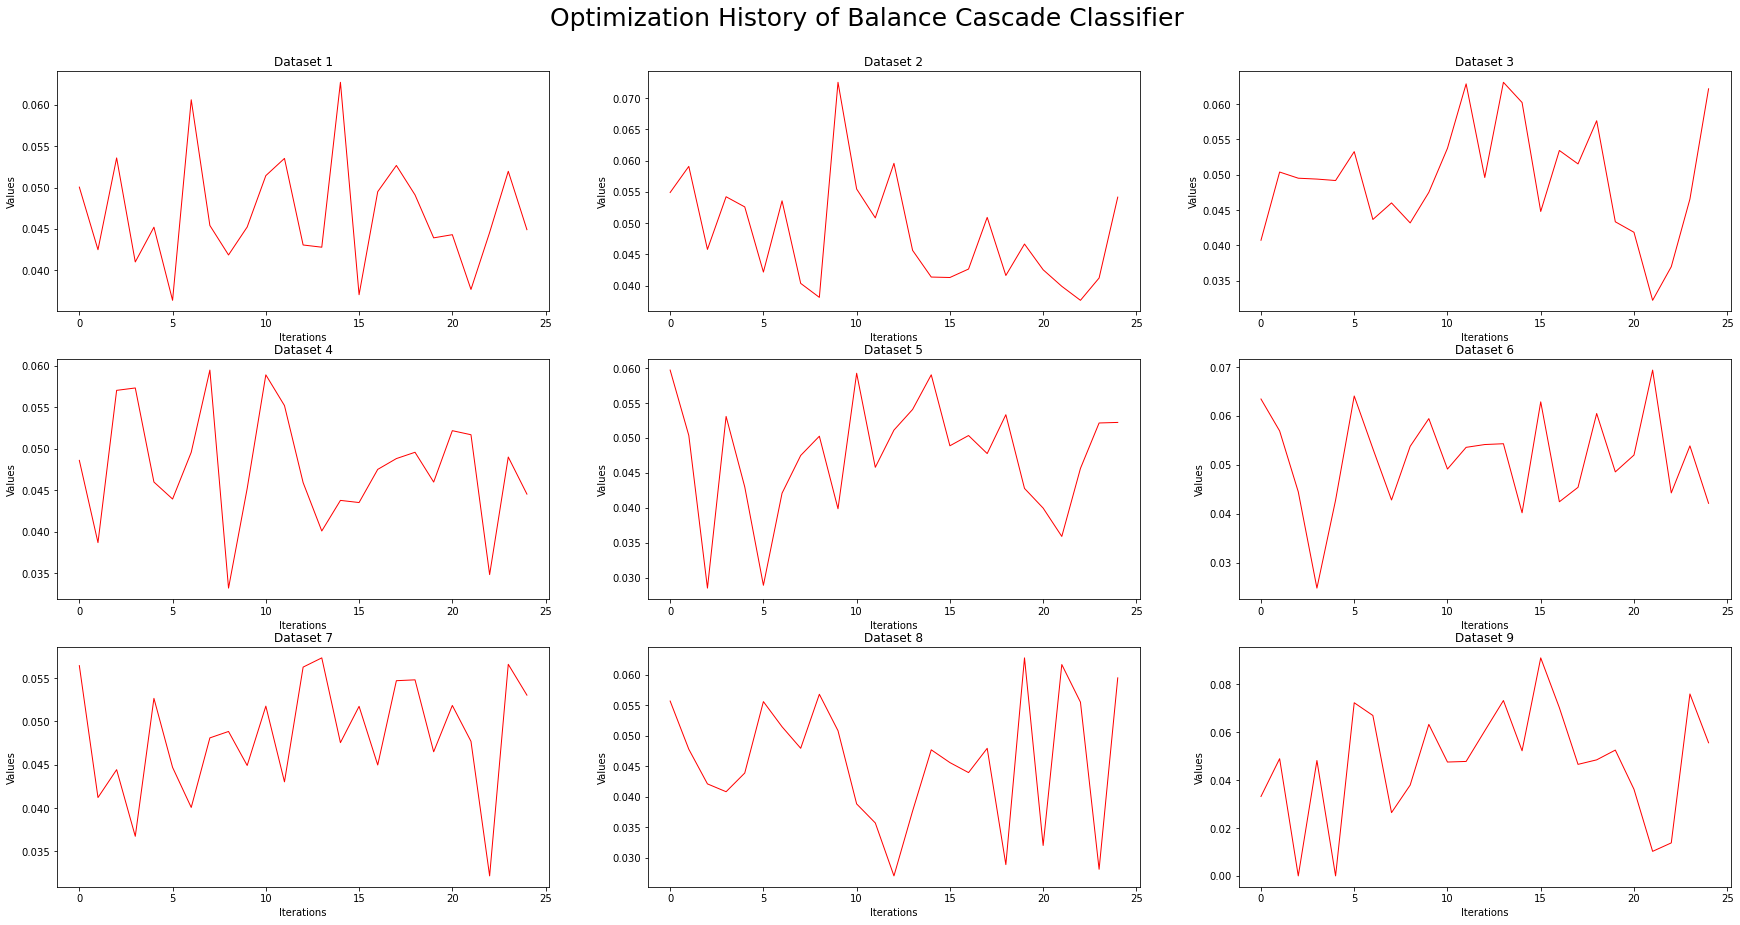

In [25]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 3, num_col = 3, model = 'Balance Cascade Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

### Classifier

#### Scheme 1

In [ ]:
table_setC = runall_cascade(run_train, run_test, base_paramC, num_iter = 5)
line_chart(table_setC, title = 'Balance Cascade Classifier Scheme 1 (LightGBM)')

In [ ]:
table_setC

#### Scheme 2


 Dataset 1:
Iteration 1:
Size before undersampling: 40092
Size after Undersampling: 9252
Size before Oversampling: 9252
Size after Oversampling: 15439
Iteration 2:
Size before undersampling: 27322
Size after Undersampling: 9252
Size before Oversampling: 9252
Size after Oversampling: 15398
Iteration 3:
Size before undersampling: 18783
Size after Undersampling: 9252
Size before Oversampling: 9252
Size after Oversampling: 15432
Iteration 4:
Size before undersampling: 13072
Size after Undersampling: 9252
Size before Oversampling: 9252
Size after Oversampling: 15407
Iteration 5:
Size before undersampling: 9253
Stop Undersampling !
Size before Oversampling: 9253
Size after Oversampling: 15445
Precision: 0.0013093679323890014 
Recall: 0.21568627450980393 
Aging Rate: 0.17268597504573577

 Dataset 2:
Iteration 1:
Size before undersampling: 39286
Size after Undersampling: 9066
Size before Oversampling: 9066
Size after Oversampling: 15077
Iteration 2:
Size before undersampling: 26773
Size after

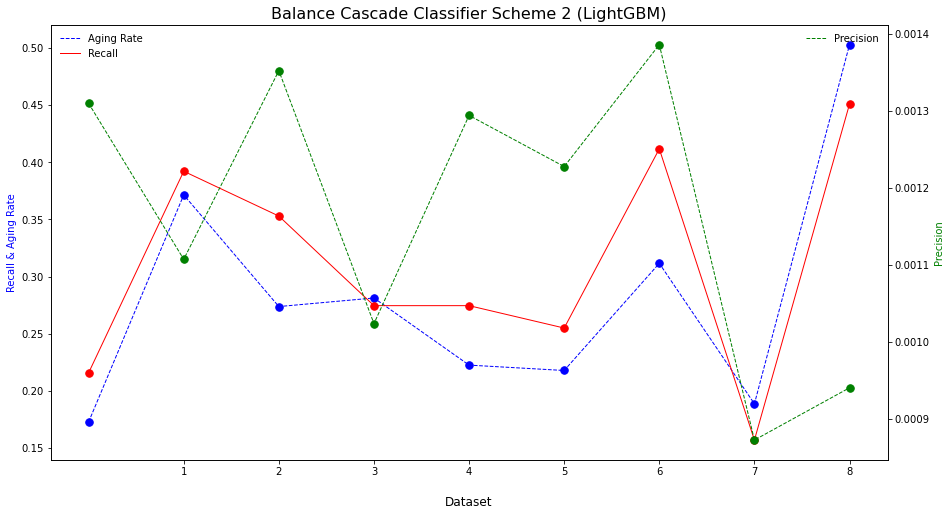

In [26]:
table_setC = runall_cascade(run_train, run_test, base_config = base_paramC, meta_config = meta_paramC)
line_chart(table_setC, title = 'Balance Cascade Classifier Scheme 2 (LightGBM)')

In [27]:
table_setC

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,F1 Score,Score
dataset 1,25.000000,38550.0,1542.0,11.0,8390.0,40.0,40208.0,0.001309,0.215686,0.172686,1.249009,0.001301,0.174811
dataset 2,25.000000,37775.0,1511.0,20.0,18050.0,31.0,30548.0,0.001107,0.392157,0.371436,1.055785,0.001104,0.282611
dataset 3,25.000000,37900.0,1516.0,18.0,13298.0,33.0,35300.0,0.001352,0.352941,0.273716,1.289444,0.001347,0.292344
dataset 4,25.000000,37950.0,1518.0,14.0,13667.0,37.0,34931.0,0.001023,0.274510,0.281219,0.976144,0.001020,0.000000
dataset 5,25.049440,38000.0,1517.0,14.0,10808.0,37.0,37790.0,0.001294,0.274510,0.222451,1.234026,0.001288,0.220652
dataset 6,25.115664,38000.0,1513.0,13.0,10580.0,38.0,38018.0,0.001227,0.254902,0.217743,1.170653,0.001221,0.197556
dataset 7,25.182240,38000.0,1509.0,21.0,15136.0,30.0,33462.0,0.001385,0.411765,0.311558,1.321630,0.001381,0.346817
dataset 8,25.000000,38000.0,1520.0,8.0,9165.0,43.0,39433.0,0.000872,0.156863,0.188555,0.831921,0.000867,0.000000
dataset 9,25.000000,7600.0,304.0,23.0,24446.0,28.0,24152.0,0.000940,0.450980,0.502970,0.896634,0.000938,0.000000


### Export

In [28]:
savedate = '20220308'
TPE_multi = False
scheme = 2

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = f'BC_scheme{scheme}_iter5_over5_nlast'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = f'BC_scheme{scheme}_iter5_over5_nlast')